In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

tickers = ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'AMZN', 'NVDA', 'META']
data_dict = {}
for ticker in tickers:
    file_path = f"../data/{ticker}.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data_dict[ticker] = df
        print(f"{ticker} loaded successfully. Shape: {df.shape}")
    else:
        print(f"{ticker} file not found!")

for ticker, df in data_dict.items():
    print(f"\n--- {ticker} preview ---")
    print(df.head())




AAPL loaded successfully. Shape: (2638, 1)
MSFT loaded successfully. Shape: (2638, 1)
TSLA loaded successfully. Shape: (2638, 1)
GOOGL loaded successfully. Shape: (2638, 1)
AMZN loaded successfully. Shape: (2638, 1)
NVDA loaded successfully. Shape: (2638, 1)
META loaded successfully. Shape: (2638, 1)

--- AAPL preview ---
            AAPL_Close
Date                  
2015-01-02   24.288580
2015-01-05   23.604332
2015-01-06   23.606554
2015-01-07   23.937571
2015-01-08   24.857307

--- MSFT preview ---
            MSFT_Close
Date                  
2015-01-02   39.998695
2015-01-05   39.630878
2015-01-06   39.049194
2015-01-07   39.545334
2015-01-08   40.708698

--- TSLA preview ---
            TSLA_Close
Date                  
2015-01-02   14.620667
2015-01-05   14.006000
2015-01-06   14.085333
2015-01-07   14.063333
2015-01-08   14.041333

--- GOOGL preview ---
            GOOGL_Close
Date                   
2015-01-02    26.319654
2015-01-05    25.818159
2015-01-06    25.180981
2015-0

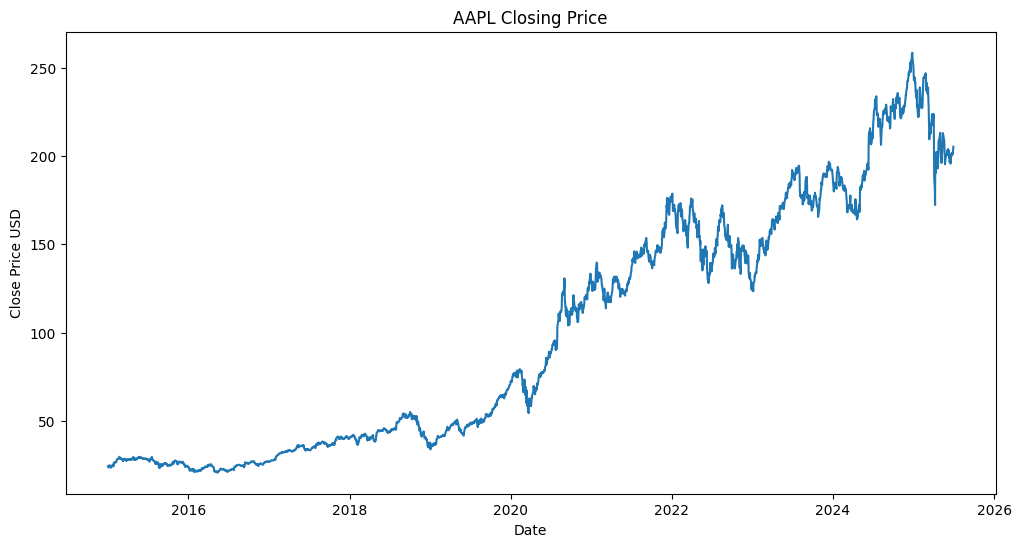

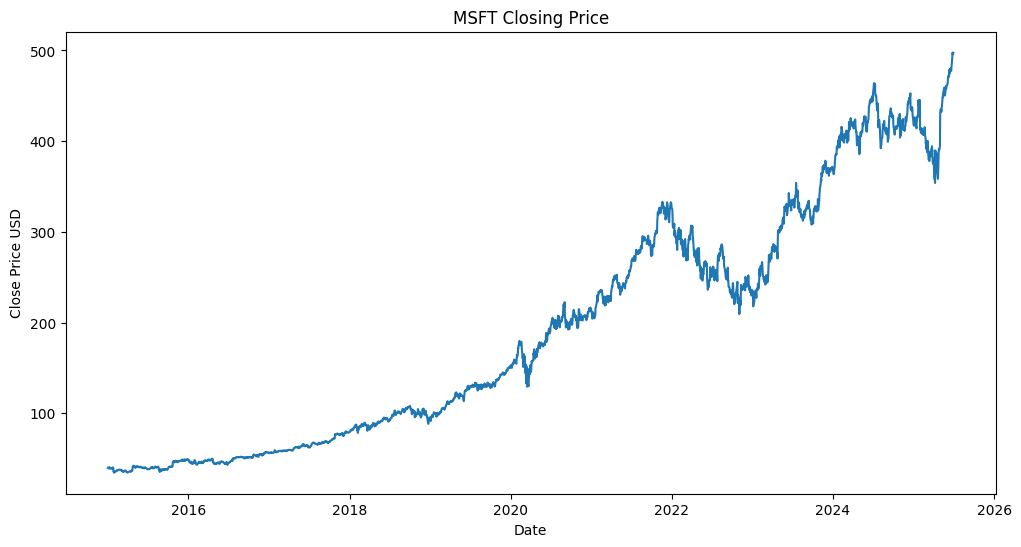

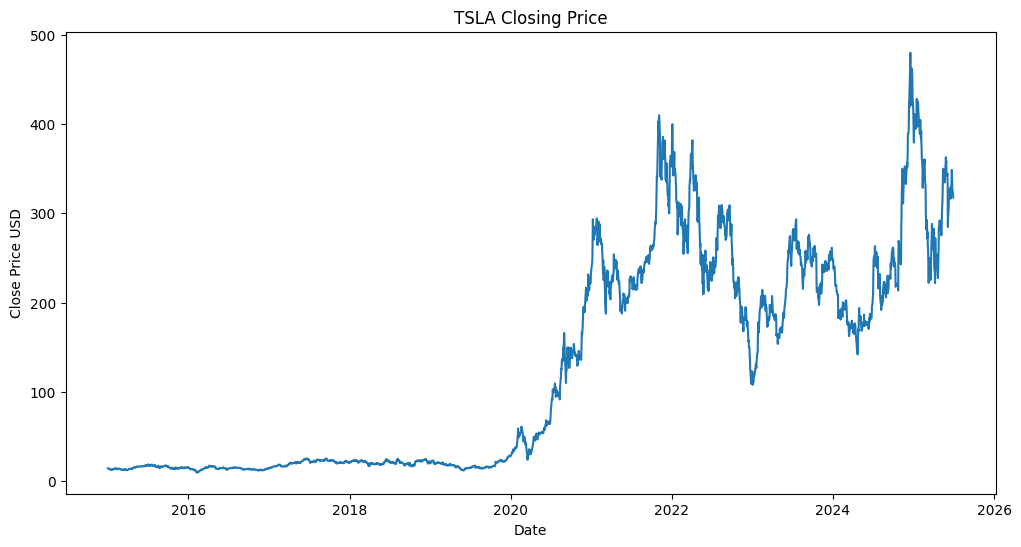

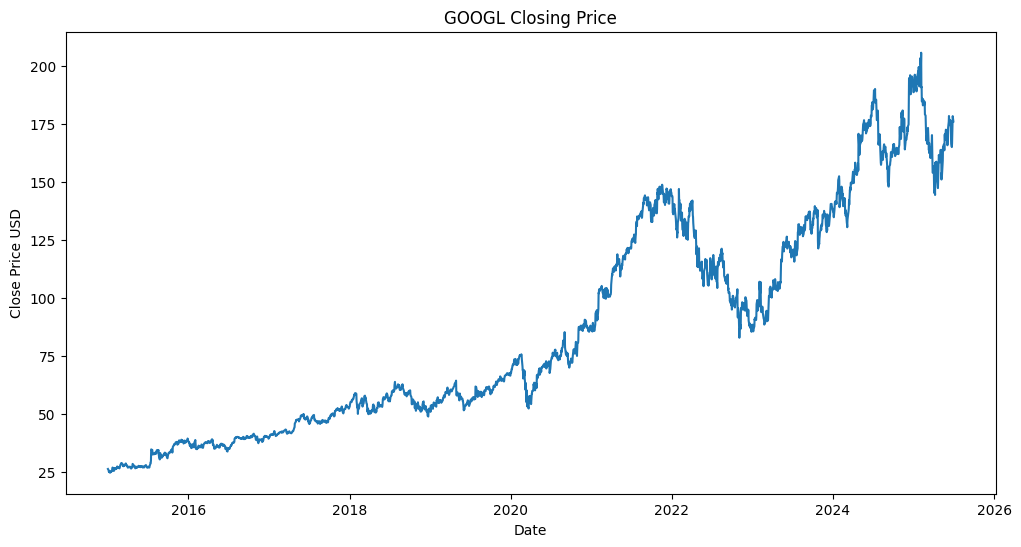

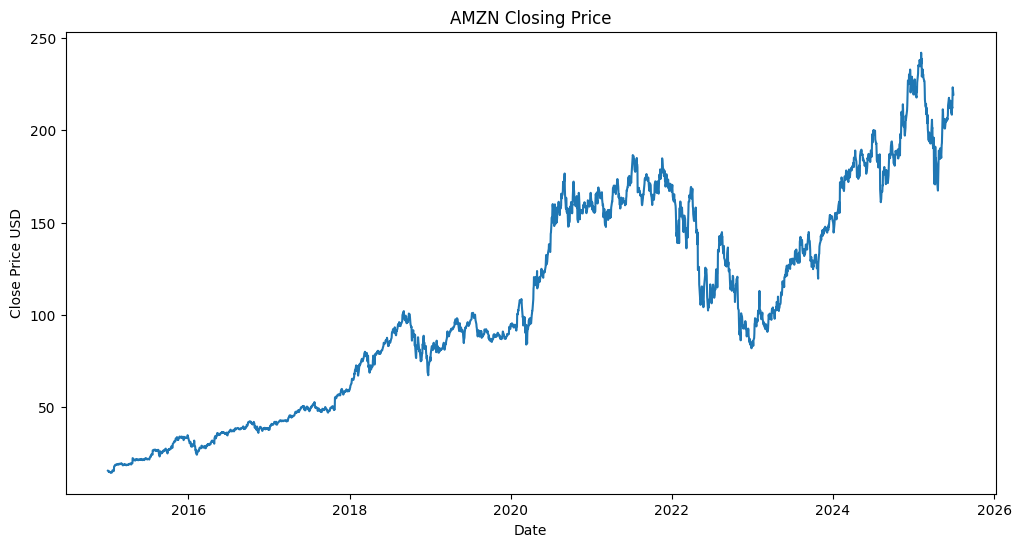

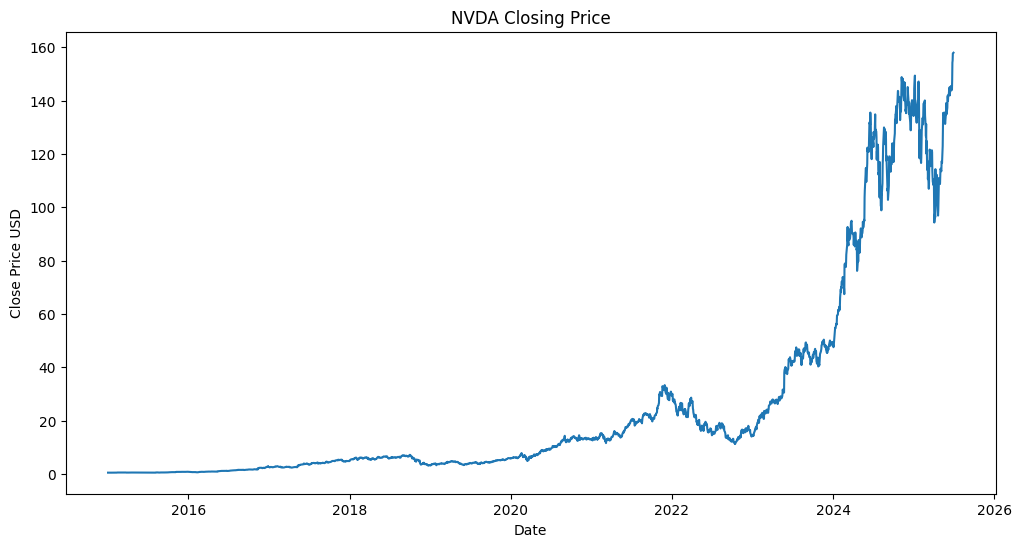

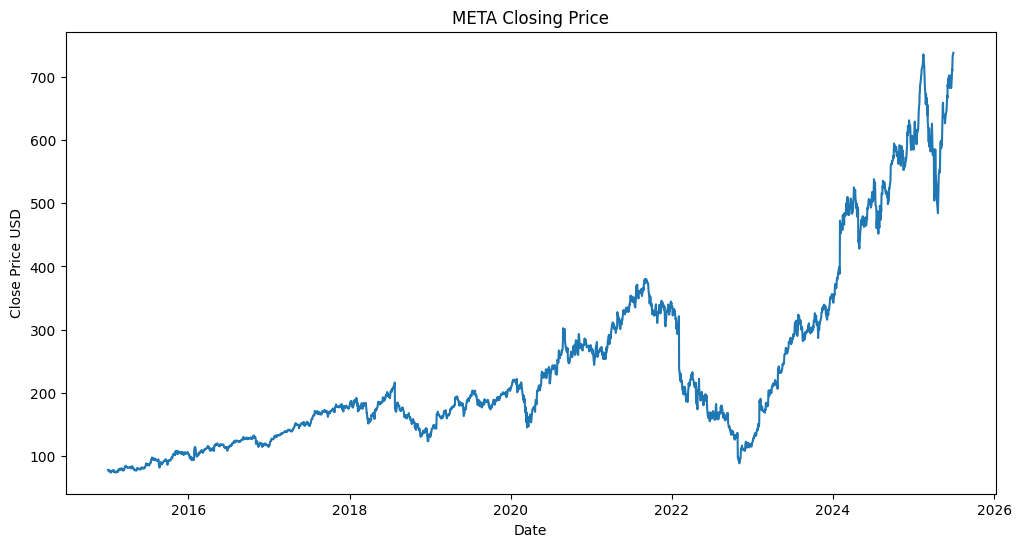

In [48]:
for ticker, df in data_dict.items():
    df.columns = ['Close']  
    df = df.reset_index()
    df.set_index('Date', inplace=True)

    # plotting for verification
    plt.figure(figsize=(12,6))
    plt.plot(df['Close'])
    plt.title(f"{ticker} Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Close Price USD")
    plt.show()

    data_dict[ticker] = df  


In [49]:
def train_and_evaluate_lstm(df, ticker):
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    from sklearn.metrics import mean_squared_error
    import math

    # Scaling our prices between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close']])

    # we'll create sequences say of lenght 60
    sequence_length = 60
    x = []
    y = []
    for i in range(sequence_length, len(scaled_data)):
        x.append(scaled_data[i-sequence_length:i, 0])   # previous 60 days
        y.append(scaled_data[i, 0])                      # next day

    x = np.array(x)
    y = np.array(y)

    x = np.reshape(x, (x.shape[0], x.shape[1], 1))

    # we'll test the model by splitting it
    training_size = int(len(x) * 0.8)
    x_train = x[:training_size]
    y_train = y[:training_size]
    x_test = x[training_size:]
    y_test = y[training_size:]

    # LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Training our model
    history = model.fit(
        x_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, y_test),
        verbose=1
    )

    # Predicting the prices
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plotting the graphs
    plt.figure(figsize=(12,6))
    plt.plot(real_prices, color='blue', label=f'Actual {ticker} Price')
    plt.plot(predicted_prices, color='red', label=f'Predicted {ticker} Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # calculating the root mean square
    rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))
    print(f"RMSE for {ticker}: {rmse}")

    # saving everything
    model.save(f'../models/{ticker}_lstm_model.h5')
    print(f"Model saved for {ticker}")



c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0122 - val_loss: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.7613e-04 - val_loss: 0.0011
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5825e-04 - val_loss: 0.0013
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.3803e-04 - val_loss: 0.0016
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5134e-04 - val_loss: 0.0011
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.0262e-04 - val_loss: 9.1722e-04
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.4097e-04 - val_loss: 0.0013
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.3996e-04 - val_loss: 0.0010
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.9913e-04 - val_loss: 0.0012
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0224e-04 - val_loss: 8.4727e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9003e-04 - val_loss: 0.0012
Epoch 12/20
65/

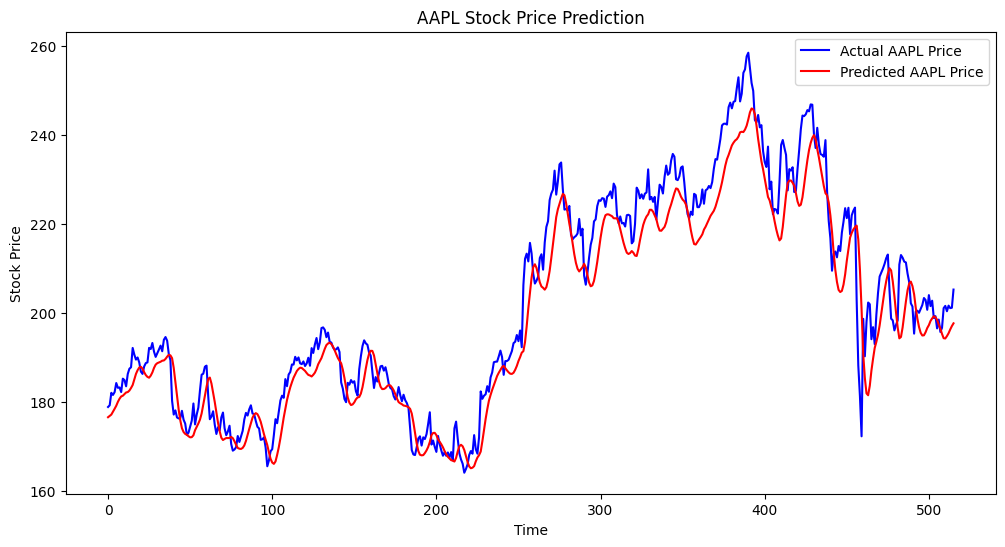

RMSE for AAPL: 7.12513744915525
Model saved for AAPL


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0209 - val_loss: 9.3809e-04
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.4247e-04 - val_loss: 9.3670e-04
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1966e-04 - val_loss: 0.0016
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.2548e-04 - val_loss: 0.0012
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1407e-04 - val_loss: 0.0016
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.1741e-04 - val_loss: 9.4338e-04
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.9035e-04 - val_loss: 0.0011
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.8268e-04 - val_loss: 8.3874e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.8853e-04 - val_loss: 0.0023
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.8334e-04 - val_loss: 7.1106e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.6320e-04 - val_loss: 9.2693e-04

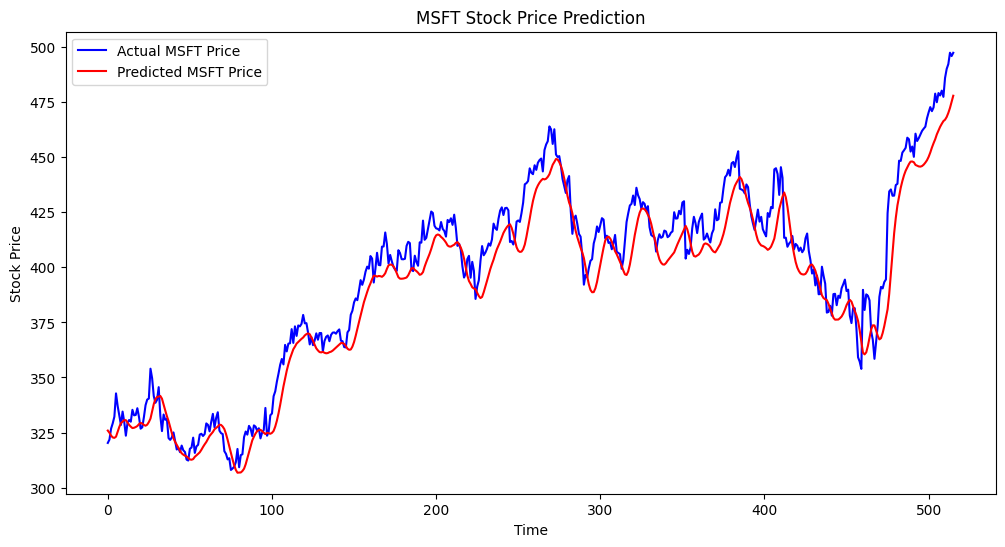

RMSE for MSFT: 11.928883702029225
Model saved for MSFT


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0191 - val_loss: 0.0030
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.3908e-04 - val_loss: 0.0029
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 8.9800e-04 - val_loss: 0.0026
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.3132e-04 - val_loss: 0.0021
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.5097e-04 - val_loss: 0.0018
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.8605e-04 - val_loss: 0.0018
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.7600e-04 - val_loss: 0.0016
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.8270e-04 - val_loss: 0.0015
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.0088e-04 - val_loss: 0.0017
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.9849e-04 - val_loss: 0.0014
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.9993e-04 - val_loss: 0.0012
Epoch 12/20
65/65 ━━━━━

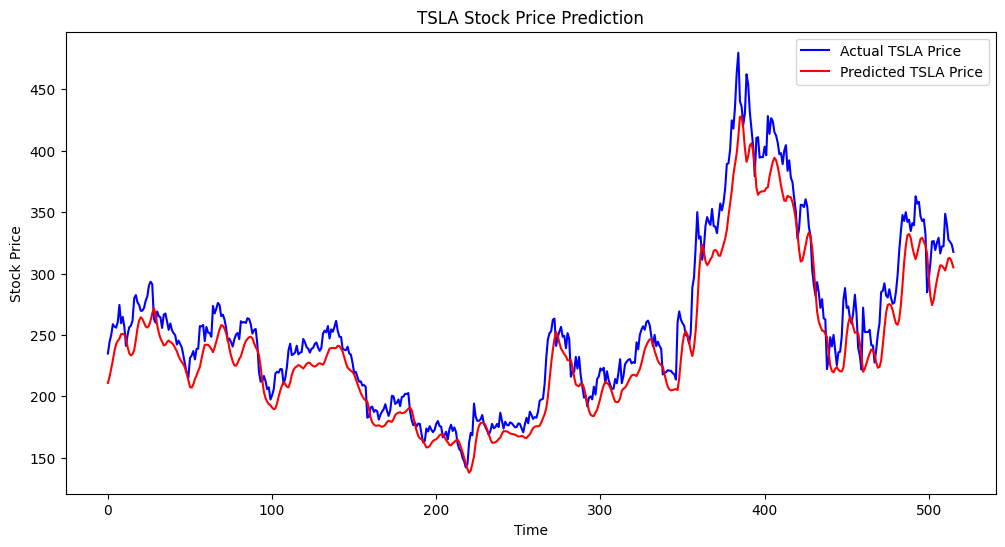

RMSE for TSLA: 22.3597773035107
Model saved for TSLA


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0170 - val_loss: 0.0011
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.5522e-04 - val_loss: 0.0016
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.7086e-04 - val_loss: 0.0011
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.6985e-04 - val_loss: 0.0018
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.1347e-04 - val_loss: 0.0012
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.7480e-04 - val_loss: 0.0011
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.4957e-04 - val_loss: 0.0017
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.9273e-04 - val_loss: 0.0017
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.8764e-04 - val_loss: 0.0011
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.1526e-04 - val_loss: 8.6750e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1572e-04 - val_loss: 9.5837e-04
Epoch 12/20
65/

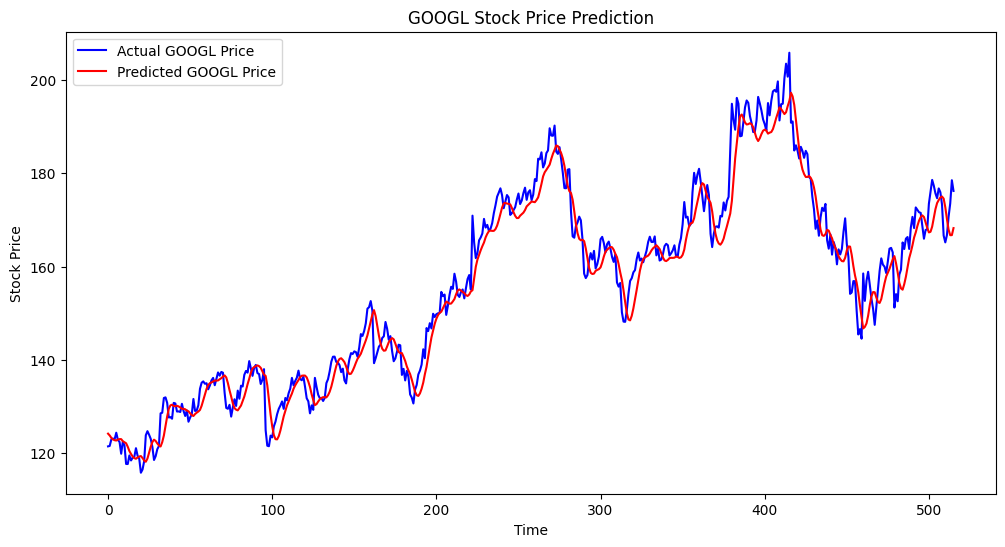

RMSE for GOOGL: 4.518267810386168
Model saved for GOOGL


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0223 - val_loss: 0.0012
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.7381e-04 - val_loss: 0.0011
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.4388e-04 - val_loss: 0.0019
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.2035e-04 - val_loss: 0.0012
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.0414e-04 - val_loss: 9.4890e-04
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.6672e-04 - val_loss: 0.0016
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.3058e-04 - val_loss: 8.8770e-04
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.5219e-04 - val_loss: 8.2188e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.7255e-04 - val_loss: 0.0017
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.7818e-04 - val_loss: 6.7624e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.7129e-04 - val_loss: 7.2973e-04
Epo

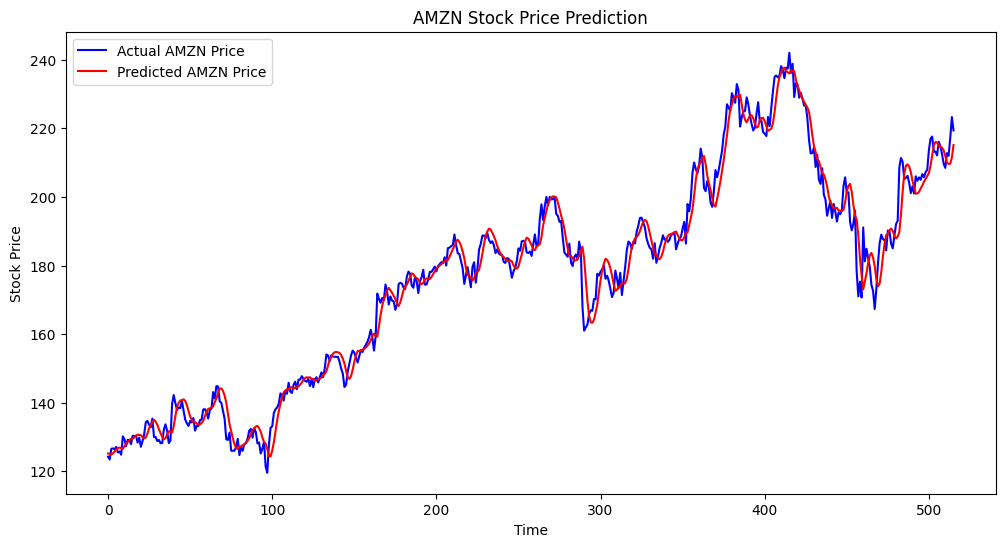

RMSE for AMZN: 4.5669216293350985
Model saved for AMZN


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.0251e-05 - val_loss: 0.0026
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.3251e-05 - val_loss: 0.0020
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.8499e-05 - val_loss: 0.0026
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.5432e-05 - val_loss: 0.0020
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.9485e-05 - val_loss: 0.0018
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.0648e-05 - val_loss: 0.0028
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.4884e-05 - val_loss: 0.0018
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.1171e-05 - val_loss: 0.0022
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8851e-05 - val_loss: 0.0017
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6114e-05 - val_loss: 0.0016
Epoch 12/20
65/65 ━━━━━

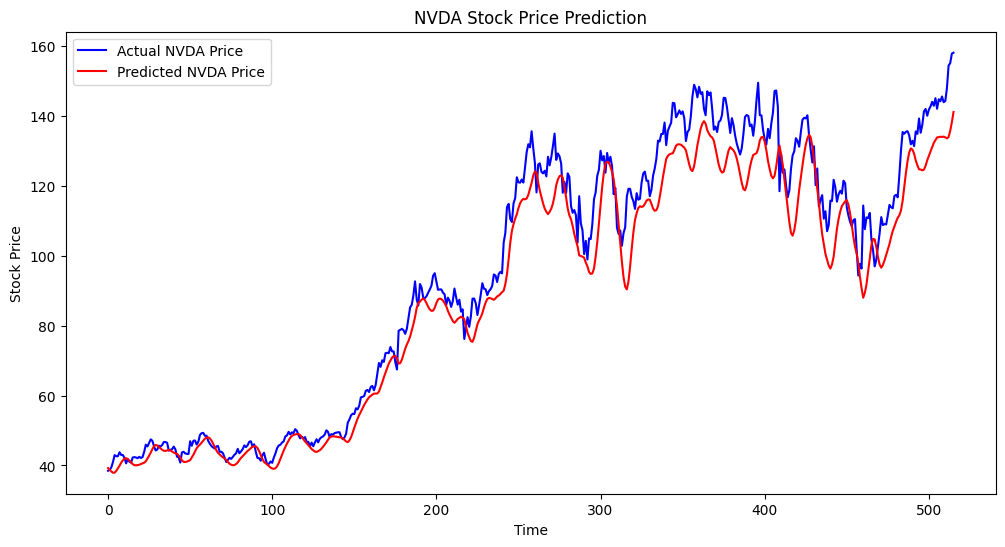

RMSE for NVDA: 8.824316696878792
Model saved for NVDA


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.5356e-04 - val_loss: 0.0016
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.5376e-04 - val_loss: 0.0020
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.9186e-04 - val_loss: 0.0017
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.9992e-04 - val_loss: 0.0018
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.8548e-04 - val_loss: 0.0029
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.6554e-04 - val_loss: 0.0011
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.9061e-04 - val_loss: 0.0027
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.8523e-04 - val_loss: 9.9674e-04
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.3218e-04 - val_loss: 0.0026
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.9292e-04 - val_loss: 0.0012
Epoch 12/20
65/65 ━

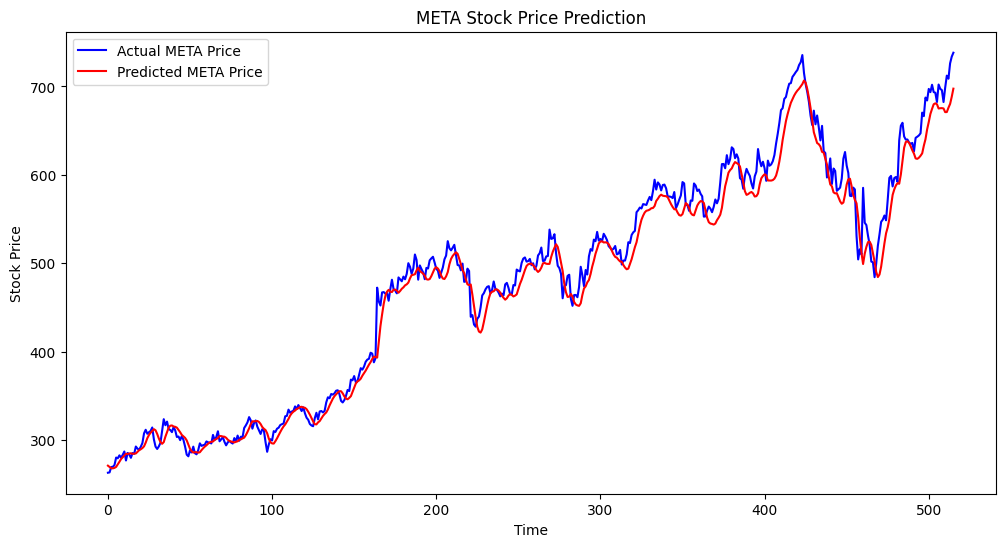

RMSE for META: 18.583254933774683
Model saved for META


In [50]:
#calling the above function
for ticker, df in data_dict.items():
    train_and_evaluate_lstm(df, ticker)